In [1]:
import pandas as pd
import numpy as np
import torch
from tqdm import tqdm
from embedders import Embedder
from database.milvusdb import MilvusDB
from query_expander import get_expander

tqdm.pandas()
embedder = Embedder.create("Qwen/Qwen3-Embedding-0.6B", device="mps", normalize=True, for_queries=True)

In [2]:
QUERY_EXPANSION = 'add_prev_3'

# from compute_difference_vector import get_sample_df
# samples = get_sample_df(14000, embedder)

In [3]:
examples = pd.read_json("data/dataset/nontrivial_checked.jsonl", lines=True)
expander = get_expander(QUERY_EXPANSION, path_to_data="data/preprocessed/reviews.jsonl")
print(f"Using query expansion: {expander}")
examples["sent_no_cit"] = expander(examples)

# Add vector column to examples
examples["vector"] = examples.progress_apply(lambda row: embedder([row["sent_no_cit"]])[0], axis=1)

# Denormalize on citation_dois (targets)
examples = examples.explode("citation_dois", ignore_index=True)
print(f"Number of samples after denormalization: {examples.shape[0]}")
examples.rename(columns={"citation_dois": "target_doi"}, inplace=True)

Using query expansion: QueryExpander(name=add_prev_3, data_length=2980)


100%|██████████| 14735/14735 [18:59<00:00, 12.94it/s] 

Number of samples after denormalization: 18801


In [4]:
examples.head()

,source_doi,sent_original,sent_no_cit,sent_idx,target_doi,pubdate,resolved_bibcodes,sent_cit_masked,vector
0,10.1016/j.newar.2024.101694,"Subsequently, Andrews et al. (2017) selected a...",1 pc. Similar separation distributions had bee...,58,10.1093/mnras/stx2000,20240601,[2017MNRAS.472..675A],"Subsequently, [REF] selected a wide binary can...","[-0.013162542, -0.09026443, -0.0120118465, -0...."
1,10.1016/j.newar.2024.101694,Andrews et al. (2017) investigated how the sep...,"Subsequently, Andrews et al. (2017) selected a...",61,10.1093/mnras/stx2000,20240601,[2017MNRAS.472..675A],[REF] investigated how the separation of their...,"[-0.07659445, -0.064264126, -0.007819046, 0.00..."
2,10.1016/j.newar.2024.101694,This led Andrews et al. (2017) to conclude tha...,Andrews et al. (2017) investigated how the sep...,64,10.1093/mnras/stx2000,20240601,[2017MNRAS.472..675A],This led [REF] to conclude that most of the pa...,"[-0.041363332, -0.067232065, -0.00943872, 0.03..."
3,10.1016/j.newar.2024.101694,It may also owe in part to the mass ratio dist...,The sample contains 97 resolved WD+MS binaries...,90,10.1093/mnras/stz2480,20240601,[2019MNRAS.489.5822E],It may also owe in part to the mass ratio dist...,"[-0.04453195, -0.07250524, -0.009316281, 0.052..."
4,10.1016/j.newar.2024.101694,Hwang et al. (2022c) used a related method to ...,This approach forward-models the distribution ...,110,10.3847/2041-8213/ac7c70,20240601,[2022ApJ...933L..32H],[REF] used a related method to study the eccen...,"[-0.04475006, -0.01653341, -0.007177436, 0.053..."


In [5]:
db = MilvusDB()
def most_similar_to_query(example: pd.Series) -> np.ndarray:
    """
    Takes in an example (with 'vector' column already set), and from the candidates
    (returned entities with that doi from the database), returns the vector most similar
    to the example's vector.

    """
    # Converts 'vector' column to rows * dim array, holding the candidate vectors
    candidates = db.select_by_doi(example.target_doi, collection_name="qwen06_chunks")
    candidate_vectors = np.stack(candidates["vector"])
    best_idx = np.argmax(np.dot(candidate_vectors, example["vector"]))
    best_vector = candidate_vectors[best_idx]
    return best_vector

In [6]:
Q = np.array(examples['vector'].tolist()).T

V = np.array([most_similar_to_query(row) for _, row in tqdm(examples.iterrows(), total=len(examples))]).T
print("Q shape:", Q.shape)
print("V shape:", V.shape)

100%|██████████| 18801/18801 [02:30<00:00, 125.31it/s]


Q shape: (1024, 18801)
V shape: (1024, 18801)


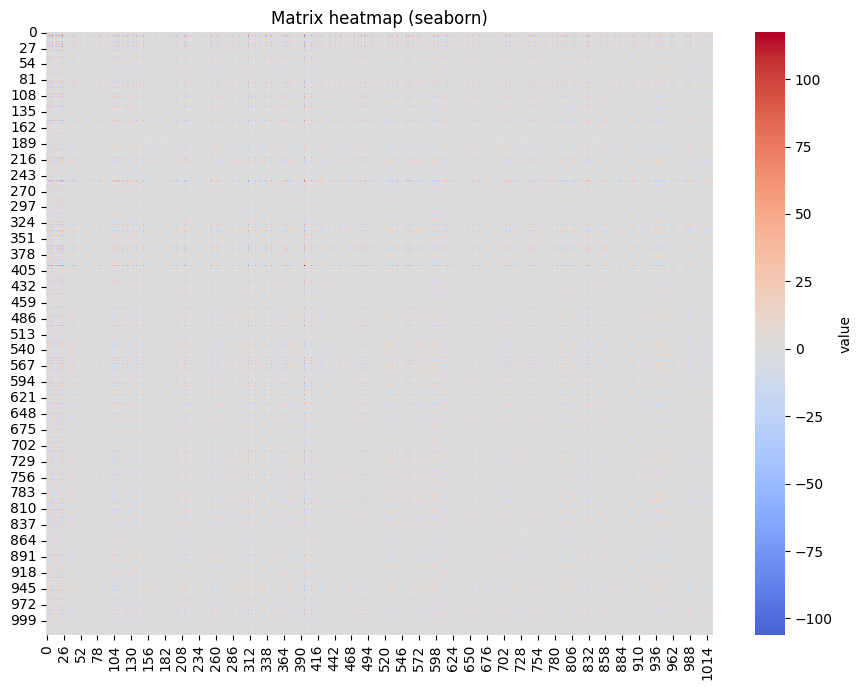

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

M = V @ Q.T
plt.figure(figsize=(9, 7))
sns.heatmap(M, cmap="coolwarm", center=0, cbar_kws={"label": "value"})  # center=0 for diverging data
plt.title("Matrix heatmap (seaborn)")
plt.tight_layout()
plt.savefig("heatmap_seaborn.png", dpi=200)
plt.show()

In [8]:

U, S, Vt = np.linalg.svd(M)
R = U @ Vt

print("det R:", np.linalg.det(R))
# if np.linalg.det(R) < 0:
#     D = np.eye(R.shape[0])
#     D[-1, -1] = -1
#     R = U @ D @ Vt
# print("corrected det R:", np.linalg.det(R))

det R: 1.000000000000274


In [20]:
print("rank approx:", np.sum(S > 1e-8))
print("singular values (top/last):", S[:30], S[-5:])

rank approx: 1024
singular values (top/last): [5935.25344473  456.21592681  350.43975695  297.03413118  263.20529045
  259.76203922  193.79528779  171.41992843  141.84932759  117.75041675
  110.57762009  110.27182225  102.30467086   89.4831875    82.35046596
   78.9513527    73.98024351   72.1792915    69.47354635   67.70392094
   64.43752283   63.17960128   59.95500489   57.48181072   56.26419064
   54.83336557   51.52233154   49.10426144   47.49220742   47.06623498] [0.00094236 0.00054155 0.00033854 0.00026215 0.00010845]


In [14]:
research_dois = set(examples.target_doi)
print(research_dois)

{'10.3847/2041-8213/ab7237', '10.1086/176723', '10.1088/2041-8205/721/1/L67', '10.1086/507300', '10.1093/mnras/stz1149', '10.1088/0004-637X/754/2/105', '10.1086/169289', '10.1016/0370-2693(88)90597-7', '10.1086/304182', '10.1038/35030032', '10.1093/mnras/170.3.633', '10.1086/307112', '10.1086/150947', '10.1117/12.2056701', '10.1051/0004-6361:20010208', '10.1093/mnras/sty3482', '10.1086/173257', '10.1086/533485', '10.1086/304502', '10.3847/0004-637X/830/1/17', '10.1051/0004-6361/201116654', '10.1093/mnras/stt2460', '10.1088/0004-637X/757/1/85', '10.1088/0004-637X/732/2/74', '10.1093/mnras/242.3.318', '10.1088/1475-7516/2009/06/021', '10.1093/mnras/sty1353', '10.1088/0004-637X/780/1/33', '10.1046/j.1365-8711.2001.04612.x', '10.1111/j.1365-2966.2012.21288.x', '10.48550/arXiv.astro-ph/9510021', '10.1086/307715', '10.1086/338081', '10.1086/339059', '10.3847/1538-4357/aaa4b4', '10.1093/mnras/stt1822', '10.1086/342362', '10.1086/382591', '10.1086/114134', '10.1086/185868', '10.1086/181651', '

In [15]:
import random

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))


def negative_vectors(example: pd.Series, n=5):
    # Get all target DOIs for this example, sample from those not cited
    rows = examples[(examples.source_doi == example.source_doi) & (examples.sent_idx == example.sent_idx)]
    citation_dois = set(rows.target_doi)
    neg_dois = list(research_dois - citation_dois)
    neg_samples = random.sample(neg_dois, n)
    
    # Get vectors for negative samples
    neg_vectors = np.zeros((n, embedder.dim))
    for i, doi in enumerate(neg_samples):
        records = db.select_by_doi(doi, collection_name="qwen06_chunks")
        sample_record = records.sample(n=1).iloc[0]
        neg_vectors[i] = np.array(sample_record['vector'])
    return neg_vectors


res = negative_vectors(examples.iloc[998])
print(res)

[[-0.0346026  -0.02140541 -0.01019946 ... -0.03647742 -0.00208141
   0.03959997]
 [ 0.00548993 -0.03189964 -0.01024159 ...  0.00026397  0.07475921
   0.0073039 ]
 [-0.03145466 -0.01404694 -0.00997663 ... -0.05796941  0.00506952
   0.00616993]
 [ 0.03414909 -0.06713969 -0.00993746 ... -0.03803044  0.04781603
  -0.03437707]
 [-0.02193882  0.01014205 -0.00875814 ... -0.05116607  0.01794827
  -0.04295648]]


Citation DOIs: {'10.1046/j.1365-8711.2000.03810.x', '10.1086/316394', '10.1086/186883'}

In [17]:
differences_to_target = []
differences_to_negative = []
for _, row in examples.iterrows():
    query_vector = row['vector']
    target_vector = most_similar_to_query(row)
    aligned_query_vector = R @ query_vector
    before = cosine_similarity(query_vector, target_vector)
    after = cosine_similarity(aligned_query_vector, target_vector)

    differences_to_target.append(after - before)
    neg_vectors = negative_vectors(row, n=5)
    batch_distance_to_negative = []
    for neg_vector in neg_vectors:
        before_neg = cosine_similarity(query_vector, neg_vector)
        after_neg = cosine_similarity(aligned_query_vector, neg_vector)
        batch_distance_to_negative.append(after_neg - before_neg)
        differences_to_negative.append(after_neg - before_neg)
    print(_)
    print(f"Improvement to target: {after - before:.4f}")
    print(f"Distance to negatives: {np.mean(batch_distance_to_negative):.4f} ± {np.std(batch_distance_to_negative):.4f}")
    print("---")
print(f"Average improvement (target): {np.mean(differences_to_target):.6f} ± {np.std(differences_to_target):.6f}")
print(f"Average improvement (negative): {np.mean(differences_to_negative):.6f} ± {np.std(differences_to_negative):.6f}")

0
Improvement to target: 0.0033
Distance to negatives: 0.0021 ± 0.0081
---
1
Improvement to target: -0.0003
Distance to negatives: -0.0019 ± 0.0049
---
2
Improvement to target: 0.0256
Distance to negatives: 0.0030 ± 0.0113
---
3
Improvement to target: 0.0186
Distance to negatives: 0.0078 ± 0.0109
---
4
Improvement to target: 0.0111
Distance to negatives: 0.0063 ± 0.0068
---
5
Improvement to target: 0.0256
Distance to negatives: -0.0021 ± 0.0052
---
6
Improvement to target: -0.0042
Distance to negatives: -0.0031 ± 0.0075
---
7
Improvement to target: -0.0010
Distance to negatives: 0.0075 ± 0.0061
---
8
Improvement to target: 0.0138
Distance to negatives: 0.0081 ± 0.0056
---
9
Improvement to target: -0.0094
Distance to negatives: 0.0004 ± 0.0070
---
10
Improvement to target: 0.0220
Distance to negatives: -0.0045 ± 0.0083
---
11
Improvement to target: 0.0053
Distance to negatives: 0.0043 ± 0.0059
---
12
Improvement to target: 0.0070
Distance to negatives: -0.0051 ± 0.0079
---
13
Improvemen

In [18]:
print(R.shape)

(1024, 1024)


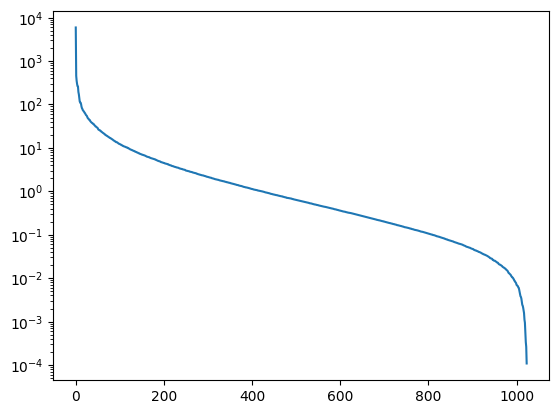

In [19]:
import matplotlib.pyplot as plt
# U, S, Vt = np.linalg.svd(M)
# print("U shape:", U.shape)
# print("S shape:", S.shape)
# print("Vt shape:", Vt.shape)
# print("Vt_trunc shape:", Vt[:1, :].shape)
# print("S_trunc shape:", S[:1].shape)
# print("U_trunc shape:", U[:, 0:1].shape)
# trunc = U[:, 0:1] @ (S[:1] * Vt[0:1, :])
# print("trunc shape:", trunc.shape)
# print("trunc rank:", np.linalg.matrix_rank(trunc))
# print(trunc)


plt.semilogy(S)  # plot singular values

In [ ]:
np.save('qwen06_chunks_rotation_n2000.npy', R)

In [ ]:
sigma1 = S[0]
eps = 1e-6  # try 1e-6 .. 1e-8 as needed
r = 50
# r = np.searchsorted(S / sigma1 < eps, True)  # first index where ratio < eps
print(f"Chosen rank r: {r}")
if r == 0:
    r = len(S)  # fallback if no small ones found
# alternative: r = np.searchsorted(np.cumsum(S**2) / np.sum(S**2), 0.99) + 1

# build small rotation in top-r
Ur = U[:, :r]  # n x r
Vr = Vt[:r, :].T  # n x r  (since Vt[:r,:] is r x n)
Msmall = Ur.T @ M @ Vr  # should be r x r but simpler compute: Tproj.T @ Qproj if you had them
# simpler: compute r x r cross-covariance directly via projections:
# Qproj = Q_all @ Ur  # expensive if many, but doable; here we reuse M decomposition
# but we can use SVD of the small Mslice: compute Us, Ss, Vts = svd(Ur.T @ M @ Vr)

# directly SVD the r x r matrix (numerically stable):
Us, Ss, Vts = np.linalg.svd(Ur.T @ M @ Vr, full_matrices=False)
Rsmall = Us @ Vts
# ensure proper rotation (det +1)
if np.linalg.det(Rsmall) < 0:
    D = np.eye(r)
    D[-1, -1] = -1
    Rsmall = Us @ D @ Vts

# map basis Ur to rotated basis Ur @ Rsmall @ Ur.T, then add identity on complement
R_full = Ur @ Rsmall @ Ur.T + (np.eye(1024) - Ur @ Ur.T)
print("det R_full:", np.linalg.det(R_full))
print(R_full.shape)
print(R_full)

In [ ]:
np.save('qwen06_chunks_r50.npy', R_full)